In [1]:
# 라이브러리 불러오기
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import randint,uniform
from collections import Counter


import re
from hanspell import spell_checker
from tqdm import tqdm
from konlpy.tag import Okt
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier
from gensim.models import word2vec

# 데이터 불러오기

In [7]:
# 텍스트 파일의 경로
file_path = '/content/kmhas_train.txt'
file_path1 = '/content/kmhas_valid.txt'
file_path2 = '/content/kmhas_test.txt'

# 파일 데이터프레임 저장
train = pd.read_csv(file_path, delimiter='\t', encoding='utf-8')
valid = pd.read_csv(file_path1, delimiter='\t', encoding='utf-8')
test = pd.read_csv(file_path2, delimiter='\t', encoding='utf-8')

In [8]:
# 데이터 병합
data = pd.concat([train, valid, test]).reset_index(drop=True)
data

,document,label
0,자한당틀딱들.. 악플질 고만해라.,"2,4"
1,정치적으로 편향된 평론한은 분은 별로...,8
2,적당히좀 쳐먹지.그랬냐??? 안그래도 문재인 때문에 나라 엉망진창인데...,2
3,안서는 아재들 풀발기 ㅋㄲㅋ,4
4,우와 ㅋ 능력자,8
...,...,...
109687,신천지들 소원대로 전부 하느님 곁으로 보내주세요,7
109688,댓글보니 다 언니사랑해요 언니언니 거리네확실히 뷰티유튜버라 여자들 댓글이 대부분이네,5
109689,중국이란 나라의 수준을 고스란히 보여주네...,8
109690,김새롬같은 철부지를 아내로 받아드린게 잘못ㅠㅠ 힘내세요ㅠㅠ,8


# 데이터 전처리

In [16]:
#레이블 개수가 2개 이상인 데이터 여부 확인
data.head(10)

,document,label
0,자한당틀딱들.. 악플질 고만해라.,"2,4"
1,정치적으로 편향된 평론한은 분은 별로...,8
2,적당히좀 쳐먹지.그랬냐??? 안그래도 문재인 때문에 나라 엉망진창인데...,2
3,안서는 아재들 풀발기 ㅋㄲㅋ,4
4,우와 ㅋ 능력자,8
5,맛녀석 콩트보다 약했음맛녀석 애청자로써 70%실력발휘,8
6,주영훈 솔직히 호감임 잉꼬부부로 소문났잖아,8
7,이게주간아이돌이랑머가달라...,8
8,아오 슈박 회사생활도 졑깥고 돈벌기 힘들어 죽겠구만 뭔 저딴것들 자꾸 tv나와서 사...,3
9,문재인 하는게 뭐 별거있냐?ㅂㅅㅅㅋ가 하는짓인데 어련하겠어.ㅋㅋㅋ,"2,3"


In [17]:
#레이블의 개수가 2개 이상인 데이터 제거
data = data[data['label'].str.len() < 2]
data.reset_index(drop=True,inplace=True)
data

,document,label
0,정치적으로 편향된 평론한은 분은 별로...,8
1,적당히좀 쳐먹지.그랬냐??? 안그래도 문재인 때문에 나라 엉망진창인데...,2
2,안서는 아재들 풀발기 ㅋㄲㅋ,4
3,우와 ㅋ 능력자,8
4,맛녀석 콩트보다 약했음맛녀석 애청자로써 70%실력발휘,8
...,...,...
96080,신천지들 소원대로 전부 하느님 곁으로 보내주세요,7
96081,댓글보니 다 언니사랑해요 언니언니 거리네확실히 뷰티유튜버라 여자들 댓글이 대부분이네,5
96082,중국이란 나라의 수준을 고스란히 보여주네...,8
96083,김새롬같은 철부지를 아내로 받아드린게 잘못ㅠㅠ 힘내세요ㅠㅠ,8


### 레이블 정보
- 0: 출신차별
- 1: 외모차별
- 2: 정치성향차별
- 3: 혐오욕설
- 4: 연령차별
- 5: 성차별
- 6: 인종차별
- 7: 종교차별
- 8: 해당사항없음

<Axes: xlabel='label', ylabel='count'>

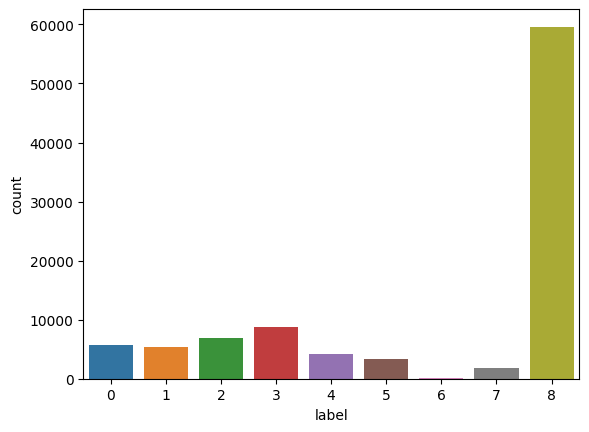

In [19]:
# 레이블 별 데이터 수 확인
sns.countplot(x='label', data = data, order=data['label'].value_counts().index.sort_values())

In [ ]:
data['label'].value_counts()

label
8    59615
3     8795
2     6931
0     5739
1     5443
4     4192
5     3348
7     1862
6      160
Name: count, dtype: int64

In [ ]:
# 레이블 병합 (출신차별과 인종차별 결합)
data['label'] = data['label'].replace('6', '1')
data['label'] = data['label'].replace('7', '6')
data['label'] = data['label'].replace('8', '7')

/var/folders/r0/bfmtv6vj16xfh7yxp6rclbn40000gn/T/ipykernel_11878/972106008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].replace('6', '1')
/var/folders/r0/bfmtv6vj16xfh7yxp6rclbn40000gn/T/ipykernel_11878/972106008.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].replace('7', '6')
/var/folders/r0/bfmtv6vj16xfh7yxp6rclbn40000gn/T/ipykernel_11878/972106008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

### 전처리 후 레이블 정보
- 0: 출신차별 & 인종차별
- 1: 외모차별
- 2: 정치성향차별
- 3: 혐오욕설
- 4: 연령차별
- 5: 성차별
- 6: 종교차별
- 7: 해당사항없음

In [ ]:
data['label'].value_counts()

label
7    59615
3     8795
2     6931
0     5739
1     5603
4     4192
5     3348
6     1862
Name: count, dtype: int64

# 텍스트 전처리

### 한글, 숫자 전처리

In [ ]:
clean = []

for text in data['document']:
    cleaned_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ0-9 ]', '', text) # 한글, 숫자 제외 공백 처리
    clean.append(cleaned_text)

clean

['정치적으로 편향된 평론한은 분은 별로',
 '적당히좀 쳐먹지그랬냐 안그래도 문재인 때문에 나라 엉망진창인데',
 '안서는 아재들 풀발기 ㅋㄲㅋ',
 '우와 ㅋ 능력자',
 '맛녀석 콩트보다 약했음맛녀석 애청자로써 70실력발휘',
 '주영훈 솔직히 호감임 잉꼬부부로 소문났잖아',
 '이게주간아이돌이랑머가달라',
 '아오 슈박 회사생활도 졑깥고 돈벌기 힘들어 죽겠구만 뭔 저딴것들 자꾸 나와서 사람 짜증나게하냐 외국서 편히살려면 아닥하고 살아라 대한민국서 취미로 돈벌어가지말고 좀 끄지라고',
 '공통점은 한국남자',
 '이재진은 그게문제가아니자나 지금 ㅋㅋㅋㅋ',
 '야이  색햐 주체사상 황장엽 국립묘지에 십어넣은 이명박은 어쩔래 드으응아',
 '소지섭 걸어다니는 인간 수면제나피디가 편집을 잘하겠지만걱정된다ㅠㅠ',
 '원중씨 잘가요 잘살아요',
 '50어 애나서 언제 길러요',
 '정신나간년들 나라 돌아가는건 1도 모르지',
 '중국은 무슨 암덩어리 같음 어떻게 저렇게 세계각지에 골고루 민폐만 끼치냐',
 '알바풀었나 많이본뉴스 이프로그램기사 댓글하고 반응이 180도 다르네 ㅋㅋㅋ 의미없는 찬양질 왜케많냐 여긴',
 '택이 아부지 카리스마 뿜뿜',
 '기사에 낚이는 ㅂㅅ같은 댓글러들',
 '김태리 나 3대째 돼지농장주 고석환의 신부후보 16위 하지만 오늘 9위로 올라갔다 좀더 분발해라',
 '지가 괜찮다는데 니들은 좀 닥치고있어라 대리도 못단 새3끼들이 말은 존나게 많네 ㅋㅋ',
 '대체 모자란게 뭐지 완벽하네',
 '다들 오지랖 좀되게 할 짓 없어보여요',
 '찌질한 새끼들 왜 동양 남자는 무섭냐',
 '개나소나 트로트 가수래 노래 존나 못부르네',
 '절세미녀라 좋아했었는데 통수친거보고 정뚝떨 여우짓 ㅈㄴ싫음ㅋㅋㅋㅋㅋ 무튼 행쇼',
 '지인이란넘지인 맞어 ㅋㅋ',
 '송중기는 사진에도 없구만ㅋㅋ송혜교고양이ㅋㅋㅋ',
 '도대체 ㅋㅋㅋㅋ어디서 방송사 갑질이 튀어나온거 지금까지 밝혀진 사실은 전부 고현정 갑질이던데ㅋㅋㅋㅋㅋㅋ촬영거부 감독지시거부 촬영이탈 밀치고욕하

### 맞춤법 검사기

In [ ]:
spelled=[]
delete=[]

for text in tqdm(clean):
    spelled_text = spell_checker.check(text)
    spelled.append(spelled_text.checked)

spelled

100%|███████████████████████████████████| 96085/96085 [1:44:38<00:00, 15.30it/s]


['정치적으로 편향된 평론 한은 분은 별로',
 '적당히 좀 처먹지 그랬냐 안 그래도 문재인 때문에 나라 엉망진창인데',
 '안 서는 아재들 풀 발기 ㅋㄲㅋ',
 '우와 ㅋ 능력자',
 '맛 녀석 콩트보다 약했음만 녀석 애청자로써 70실력 발휘',
 '주영훈 솔직히 호감임 잉꼬부부로 소문났잖아',
 '이게 주간아이돌이랑 머가 달라',
 '아오 슈박 회사 생활도 졑깥고 돈 벌기 힘들어 죽겠구먼 뭔 저딴 것들 자꾸 나와서 사람 짜증 나게 하냐 외국서 편히 살려면 아닥하고 살아라 대한민국서 취미로 돈 벌어가지 말고 좀 끄지라고',
 '공통점은 한국 남자',
 '이재진은 그게 문제가 아니잖아 지금 ㅋㅋㅋㅋ',
 '야 이  색향 주체사상 황장엽 국립묘지에 싶어 넣은 이명박은 어쩔래 드의 응아',
 '소지섭 걸어 다니는 인간 수면제나 피디가 편집을 잘하겠지만걱정된다ㅠㅠ',
 '원중 씨 잘 가요 잘 살아요',
 '50어 애나서 언제 길러요',
 '정신 나간 년들 나라 돌아가는 건 하나도 모르지',
 '중국은 무슨 암덩어리 같음 어떻게 저렇게 세계 각지에 골고루 민폐만 끼치냐',
 '알 바 풀었나 많이 본 뉴스 이 프로그램 기사 댓글하고 반응이 180도 다르네 ㅋㅋㅋ 의미 없는 찬양질 왜 이렇게 많냐 여긴',
 '택이 아버지 카리스마 뿜뿜',
 '기사에 낚이는 ㅂㅅ같은 댓글로 들',
 '김태리 나 3대째 돼지농장주 고석완의 신부 후보 16위 하지만 오늘 9위로 올라갔다 좀 더 분발해라',
 '자기가 괜찮다는데 너희들은 좀 닥치고 있어라 대리도 못단 새 3끼들이 말은 존나게 많네 ㅋㅋ',
 '대체 모자란 게 뭐지 완벽하네',
 '다들 오지랖 좀되게 할 짓 없어 보여요',
 '지질한 새끼들 왜 동양 남자는 무섭냐',
 '개나 소나 트로트 가수래 노래 존나 못 부르네',
 '절세 미녀라 좋아했었는데 통수 친구 보고 정 뚝 떨 여우짓 전 싫음ㅋㅋㅋㅋㅋ 아무튼 행쇼',
 '지인이란 넘지 인 맞아 ㅋㅋ',
 '송중기는 사진에도 없구먼ᄏᄏ송혜교 고양이ᄏᄏᄏ',
 '도대체 ㅋㅋㅋㅋ어디서 

In [ ]:
data['spelled']=spelled
data.to_csv('text.csv', index = False)

/var/folders/r0/bfmtv6vj16xfh7yxp6rclbn40000gn/T/ipykernel_11878/1548188484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['spelled']=spelled


### 단어 토큰화 및 품사 전처리

In [ ]:
# 단어 토큰화 후 품사 전처리 함수
def get_base_form(text):
    okt = Okt()
    words = okt.pos(text, norm=True, stem=True)  # 형태소 분석 및 원형 복원
    base_words = []


    for word in words:
        if word[1] in ['Noun', 'Verb', 'Adjective', 'Adverb', 'Number', 'KoreanParticle', 'Exclamation']:
            # 명사, 동사, 형용사, 부사, 숫자, 감탄사, 자음기호 추출
            base_words.append(word[0])


    return ' '.join(base_words)

In [ ]:
# 전처리 후 비어있는 댓글 분류
tokens = []
delete = []
for idx,text in tqdm(enumerate(spelled)):
    sentence = get_base_form(text)
    if sentence:
        tokens.append(sentence)
    else:
        delete.append(idx)


96085it [10:17, 155.63it/s]


In [ ]:
# 비어있는 댓글 삭제
data = data.drop(delete)
data.reset_index(drop=True, inplace=True)
data['tokens'] = tokens
data

,document,label,spelled,tokens
0,정치적으로 편향된 평론한은 분은 별로...,7,정치적으로 편향된 평론 한은 분은 별로,정치 편향 되다 평론 은 분 별로
1,적당히좀 쳐먹지.그랬냐??? 안그래도 문재인 때문에 나라 엉망진창인데...,2,적당히 좀 처먹지 그랬냐 안 그래도 문재인 때문에 나라 엉망진창인데,적당하다 좀 처 먹다 그렇다 안 그래도 문재인 때문 나라 엉망 진창
2,안서는 아재들 풀발기 ㅋㄲㅋ,4,안 서는 아재들 풀 발기 ㅋㄲㅋ,안 서다 아 재 풀 발기 ㅋㄲㅋ
3,우와 ㅋ 능력자,7,우와 ㅋ 능력자,우와 ㅋ 능력자
4,맛녀석 콩트보다 약했음맛녀석 애청자로써 70%실력발휘,7,맛 녀석 콩트보다 약했음만 녀석 애청자로써 70실력 발휘,맛 녀석 콩트 약하다 음 녀석 애 청자 로써 70 실력 발휘
...,...,...,...,...
95956,신천지들 소원대로 전부 하느님 곁으로 보내주세요,6,신천지들 소원대로 전부 하느님 곁으로 보내주세요,신천지 소원 전부 하느님 곁 보내다
95957,댓글보니 다 언니사랑해요 언니언니 거리네확실히 뷰티유튜버라 여자들 댓글이 대부분이네,5,댓글 보니 다 언니 사랑해요 언니 언니 거리네 확실히 뷰티 유튜버라 여자들 댓글이 ...,댓글 보다 다 언니 사랑 하다 언니 언니 거리 확실하다 뷰티 유튜버 여자 댓글 대부분
95958,중국이란 나라의 수준을 고스란히 보여주네...,7,중국이란 나라의 수준을 고스란히 보여주네,중국 나라 수준 고스 란 히 보여주다
95959,김새롬같은 철부지를 아내로 받아드린게 잘못ㅠㅠ 힘내세요ㅠㅠ,7,김새롬 같은 철부지를 아내로 받아들인 게 잘못ㅠㅠ 힘내세요ㅠㅠ,김새롬 같다 철부지 아내 받아들이다 게 잘못 ㅠㅠ 힘내다 ㅠㅠ


# Feature Extraction & Modeling

## 훈련 세트 및 테스트 세트 나누기

In [ ]:
x_feature = data["tokens"].copy()
y_label = data["label"].copy()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_feature, y_label, test_size=0.2, random_state=42)

## BoW

In [ ]:
# BoW embedding
bow_vectorizer = CountVectorizer(analyzer='word', max_features=5000)

x_bow_train = bow_vectorizer.fit_transform(x_train)
y_train = np.array(y_train)

x_bow_test = bow_vectorizer.transform(x_test)
y_test = np.array(y_test)


## 데이터 오버 샘플링

In [ ]:
# 훈련데이터 클래스 별 데이터 개수
counts = Counter(y_train)

# 값과 빈도수를 정렬 (오름차순)
sorted_counts = sorted(counts.items())
sorted_counts

[(0, 4595),
 (1, 4495),
 (2, 5535),
 (3, 6969),
 (4, 3354),
 (5, 2703),
 (6, 1508),
 (7, 47609)]

In [ ]:
# 클래스 개수에 맞게 비율 설정
sampling_strategy = {
    0: 20000,
    1: 20000,
    2: 20000,
    3: 30000,
    4: 10000,
    5: 10000,
    6: 10000,
    7: 47609
}

In [ ]:
# 오버샘플링
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
x_bow_resampled, y_bow_resampled = smote.fit_resample(x_bow_train, y_train)

In [ ]:
# 오버 샘플링 전 개수 비교
print(f'오버 샘플링 전: {len(y_train)}')
print(f'오버 샘플링 후: {len(y_bow_resampled)}')

오버 샘플링 전: 76768
오버 샘플링 후: 167609


### 로지스틱 회귀

In [ ]:
lr = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs', C=0.3, max_iter=1000)
lr.fit(x_bow_resampled, y_bow_resampled)

LogisticRegression(C=0.3, max_iter=1000, multi_class='multinomial',
                   random_state=42)

In [ ]:
y_pred = lr.predict(x_bow_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7060386599280988

### 나이브 베이즈

In [ ]:
nb = MultinomialNB(alpha=1.2)
nb.fit(x_bow_resampled, y_bow_resampled)

MultinomialNB(alpha=1.2)

In [ ]:
y_pred = lr.predict(x_bow_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7060386599280988

### XGBoost

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=800, tree_method='hist',random_state=42)
xgb.fit(x_bow_resampled, y_bow_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = xgb.predict(x_bow_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7826811858490075

## 기존 데이터

### 로지스틱 회귀

In [ ]:
#Logistic 랜덤서치
lr = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')

lr_param_random = {
    'C': uniform(0.1, 10),
    'max_iter': [500, 1000, 5000],
}

bow_lr_random = RandomizedSearchCV(lr, lr_param_random, n_iter=10, cv=5, refit=True, scoring='accuracy', verbose=3, random_state=42, n_jobs=1)

bow_lr_random.fit(x_bow_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .C=3.845401188473625, max_iter=500;, score=0.764 total time=  33.6s
[CV 2/5] END .C=3.845401188473625, max_iter=500;, score=0.764 total time=  24.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .C=3.845401188473625, max_iter=500;, score=0.765 total time=  33.3s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .C=3.845401188473625, max_iter=500;, score=0.763 total time=  35.5s
[CV 5/5] END .C=3.845401188473625, max_iter=500;, score=0.761 total time=  31.9s
[CV 1/5] END .C=1.934347898661638, max_iter=500;, score=0.770 total time=  19.5s
[CV 2/5] END .C=1.934347898661638, max_iter=500;, score=0.771 total time=  20.6s
[CV 3/5] END .C=1.934347898661638, max_iter=500;, score=0.771 total time=  18.5s
[CV 4/5] END .C=1.934347898661638, max_iter=500;, score=0.772 total time=  20.8s
[CV 5/5] END .C=1.934347898661638, max_iter=500;, score=0.767 total time=  18.4s
[CV 1/5] END C=6.068501579464869, max_iter=1000;, score=0.760 total time=  29.0s
[CV 2/5] END C=6.068501579464869, max_iter=1000;, score=0.761 total time=  34.2s
[CV 3/5] END C=6.068501579464869, max_iter=1000;, score=0.759 total time=  30.0s
[CV 4/5] END C=6.068501579464869, max_iter=1000;, score=0.759 total time=  30.5s
[CV 5/5] END C=6.068501579464869, max_iter=1000;, score=0.756 total time=  28.1s
[CV 1/5] END C=1.65994520336

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END .C=4.692488919658671, max_iter=500;, score=0.761 total time=  25.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .C=4.692488919658671, max_iter=500;, score=0.763 total time=  26.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END .C=4.692488919658671, max_iter=500;, score=0.762 total time=  26.0s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .C=4.692488919658671, max_iter=500;, score=0.762 total time=  25.0s
[CV 5/5] END .C=4.692488919658671, max_iter=500;, score=0.760 total time=  24.5s
[CV 1/5] END C=6.1111501174320875, max_iter=5000;, score=0.760 total time=  28.8s
[CV 2/5] END C=6.1111501174320875, max_iter=5000;, score=0.761 total time=  27.2s
[CV 3/5] END C=6.1111501174320875, max_iter=5000;, score=0.759 total time=  31.3s
[CV 4/5] END C=6.1111501174320875, max_iter=5000;, score=0.759 total time=  30.7s
[CV 5/5] END C=6.1111501174320875, max_iter=5000;, score=0.756 total time=  29.9s
[CV 1/5] END C=0.30584494295802445, max_iter=1000;, score=0.776 total time=   8.9s
[CV 2/5] END C=0.30584494295802445, max_iter=1000;, score=0.773 total time=   9.5s
[CV 3/5] END C=0.30584494295802445, max_iter=1000;, score=0.776 total time=   9.9s
[CV 4/5] END C=0.30584494295802445, max_iter=1000;, score=0.779 total time=   8.3s
[CV 5/5] END C=0.30584494295802445, max_iter=1000;, score=0.771 total time=   8.5s
[CV 1/5] END 

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(multi_class='multinomial',
                                                random_state=42),
                   n_jobs=1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f6a9b86db10>,
                                        'max_iter': [500, 1000, 5000]},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
#최적의 하이퍼파라미터
bow_lr_random.best_params_

{'C': 0.30584494295802445, 'max_iter': 1000}

In [ ]:
#교차검증 점수
print(np.max(bow_lr_random.cv_results_['mean_test_score']))

#최적의 모델 저장
bow_lr_best_model = bow_lr_random.best_estimator_

#훈련세트 점수
print(bow_lr_best_model.score(x_bow_train, y_train))

0.7748410819325546
0.8117705293872447


In [ ]:
#테스트 세트 점수
#예측
y_pred = bow_lr_best_model.predict(x_bow_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.7767415203459594
Macro Precision: 0.7432894085593447
Macro Recall: 0.5794894856898966
Macro F1 Score: 0.6428837468745385


### 나이브 베이즈

In [ ]:
#MultinomialNB 랜덤서치
nb = MultinomialNB()

nb_param_random = {
    'alpha': uniform(0.01, 10),
}

bow_nb_random = RandomizedSearchCV(nb, nb_param_random, n_iter=100, cv=5, refit=True, scoring='accuracy', verbose=3, random_state=42, n_jobs=1)

bow_nb_random.fit(x_bow_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..........alpha=3.7554011884736247;, score=0.749 total time=   0.0s
[CV 2/5] END ..........alpha=3.7554011884736247;, score=0.745 total time=   0.0s
[CV 3/5] END ..........alpha=3.7554011884736247;, score=0.745 total time=   0.0s
[CV 4/5] END ..........alpha=3.7554011884736247;, score=0.744 total time=   0.0s
[CV 5/5] END ..........alpha=3.7554011884736247;, score=0.740 total time=   0.0s
[CV 1/5] END ............alpha=9.51714306409916;, score=0.723 total time=   0.0s
[CV 2/5] END ............alpha=9.51714306409916;, score=0.721 total time=   0.0s
[CV 3/5] END ............alpha=9.51714306409916;, score=0.721 total time=   0.0s
[CV 4/5] END ............alpha=9.51714306409916;, score=0.720 total time=   0.0s
[CV 5/5] END ............alpha=9.51714306409916;, score=0.716 total time=   0.1s
[CV 1/5] END ..........alpha=7.3299394181140505;, score=0.734 total time=   0.1s
[CV 2/5] END ..........alpha=7.329939418114050

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=100, n_jobs=1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f6a99bee0b0>},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
#최적의 하이퍼파라미터
bow_nb_random.best_params_

{'alpha': 2.8193450968738074}

In [ ]:
#교차검증 점수
print(np.max(bow_nb_random.cv_results_['mean_test_score']))

#최적의 모델 저장
bow_nb_best_model = bow_nb_random.best_estimator_

#훈련세트 점수
print(bow_nb_best_model.score(x_bow_train, y_train))

0.7464828446372888
0.7700604418507712


In [ ]:
#테스트 세트 점수
#예측
y_pred = bow_nb_best_model.predict(x_bow_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.75022143489814
Macro Precision: 0.6527769166545712
Macro Recall: 0.6033457402809396
Macro F1 Score: 0.6186885801666294


### xgboost

In [ ]:
#xgboost 랜덤 서치
xgb = XGBClassifier(random_state=42)

xgb_param_random = {
    'n_estimators': np.arange(600, 1201, 200),
    'learning_rate': [0.1],
    'max_depth': np.arange(10, 17, 2),
    'tree_method': ['hist'],
}


bow_xgb_random = RandomizedSearchCV(xgb, xgb_param_random, n_iter=8, cv=3, scoring='accuracy', verbose=3, random_state=42, n_jobs=1)

bow_xgb_random.fit(x_bow_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END learning_rate=0.1, max_depth=10, n_estimators=600, tree_method=hist;, score=0.783 total time= 2.9min
[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=600, tree_method=hist;, score=0.788 total time= 2.8min
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=600, tree_method=hist;, score=0.784 total time= 2.7min
[CV 1/3] END learning_rate=0.1, max_depth=10, n_estimators=800, tree_method=hist;, score=0.783 total time= 3.6min
[CV 2/3] END learning_rate=0.1, max_depth=10, n_estimators=800, tree_method=hist;, score=0.788 total time= 3.5min
[CV 3/3] END learning_rate=0.1, max_depth=10, n_estimators=800, tree_method=hist;, score=0.784 total time= 3.6min
[CV 1/3] END learning_rate=0.1, max_depth=12, n_estimators=800, tree_method=hist;, score=0.784 total time= 4.4min
[CV 2/3] END learning_rate=0.1, max_depth=12, n_estimators=800, tree_method=hist;, score=0.788 total time= 4.4min
[CV 3/3] END learning_rate=0

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=8, n_jobs=1,
                   param_distributions={'learning_rate': [0.1],
                                        'max_depth': array([10, 12, 14, 16]),
                                        'n_estimators': array([ 600,  800, 1000, 1200]),
                                        'tree_method': ['hist']},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
#최적의 하이퍼파라미터
bow_xgb_random.best_params_

{'tree_method': 'hist',
 'n_estimators': 800,
 'max_depth': 10,
 'learning_rate': 0.1}

In [ ]:
#교차검증 점수
print(np.max(bow_xgb_random.cv_results_['mean_test_score']))

#최적의 모델 저장
bow_xgb_best_model = bow_xgb_random.best_estimator_

#훈련세트 점수
print(bow_xgb_best_model.score(x_bow_train, y_train))

0.7852230329304551
0.8627422884535223


In [ ]:
#테스트 세트 점수
#예측
y_pred = bow_xgb_best_model.predict(x_bow_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.7900797165633304
Macro Precision: 0.7578136496413799
Macro Recall: 0.6228960447509646
Macro F1 Score: 0.6751572150235097


## TF-IDF

In [ ]:
# TF-IDF embedding
tfidf_vectorizer = TfidfVectorizer(min_df = 0.0, analyzer='word', ngram_range=(1,2),max_features=5000)

x_tfidf_train = tfidf_vectorizer.fit_transform(x_train)
y_train = np.array(y_train)

x_tfidf_test = tfidf_vectorizer.transform(x_test)
y_test = np.array(y_test)

### 로지스틱 회귀

In [ ]:
#Logistic 랜덤서치
lr = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')

lr_param_random = {
    'C': uniform(0.1, 10),
    'max_iter': [500, 1000, 5000],
}

tfidf_lr_random = RandomizedSearchCV(lr, lr_param_random, n_iter=10, cv=5, refit=True, scoring='accuracy', verbose=3, random_state=42, n_jobs=1)

tfidf_lr_random.fit(x_tfidf_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .C=3.845401188473625, max_iter=500;, score=0.772 total time=  51.2s
[CV 2/5] END .C=3.845401188473625, max_iter=500;, score=0.769 total time=  30.4s
[CV 3/5] END .C=3.845401188473625, max_iter=500;, score=0.772 total time=  29.3s
[CV 4/5] END .C=3.845401188473625, max_iter=500;, score=0.773 total time=  31.0s
[CV 5/5] END .C=3.845401188473625, max_iter=500;, score=0.764 total time=  28.5s
[CV 1/5] END .C=1.934347898661638, max_iter=500;, score=0.771 total time=  20.9s
[CV 2/5] END .C=1.934347898661638, max_iter=500;, score=0.770 total time=  21.0s
[CV 3/5] END .C=1.934347898661638, max_iter=500;, score=0.771 total time=  22.7s
[CV 4/5] END .C=1.934347898661638, max_iter=500;, score=0.775 total time=  21.0s
[CV 5/5] END .C=1.934347898661638, max_iter=500;, score=0.765 total time=  21.3s
[CV 1/5] END C=6.068501579464869, max_iter=1000;, score=0.771 total time=  35.4s
[CV 2/5] END C=6.068501579464869, max_iter=1000;

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(multi_class='multinomial',
                                                random_state=42),
                   n_jobs=1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x783553d7ded0>,
                                        'max_iter': [500, 1000, 5000]},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
#최적의 하이퍼파라미터
tfidf_lr_random.best_params_

{'C': 2.2233911067827616, 'max_iter': 500}

In [ ]:
#교차검증 점수
print(np.max(tfidf_lr_random.cv_results_['mean_test_score']))

#최적의 모델 저장
tfidf_lr_best_model = tfidf_lr_random.best_estimator_

#훈련세트 점수
print(tfidf_lr_best_model.score(x_tfidf_train, y_train))

0.7706466011308313
0.8123697373905794


In [ ]:
#테스트 세트 점수
#예측
y_pred = tfidf_lr_best_model.predict(x_tfidf_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.7748137341739175
Macro Precision: 0.7462220067714174
Macro Recall: 0.5789747006896129
Macro F1 Score: 0.6434201091762524


### 나이브 베이즈

In [ ]:
#MultinomialNB 랜덤서치
nb = MultinomialNB()

nb_param_random = {
    'alpha': uniform(0.01, 10),
}

tfidf_nb_random = RandomizedSearchCV(nb, nb_param_random, n_iter=100, cv=5, refit=True, scoring='accuracy', verbose=3, random_state=42, n_jobs=1)

tfidf_nb_random.fit(x_tfidf_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..........alpha=3.7554011884736247;, score=0.674 total time=   0.0s
[CV 2/5] END ..........alpha=3.7554011884736247;, score=0.671 total time=   0.0s
[CV 3/5] END ..........alpha=3.7554011884736247;, score=0.672 total time=   0.0s
[CV 4/5] END ..........alpha=3.7554011884736247;, score=0.671 total time=   0.0s
[CV 5/5] END ..........alpha=3.7554011884736247;, score=0.673 total time=   0.0s
[CV 1/5] END ............alpha=9.51714306409916;, score=0.638 total time=   0.0s
[CV 2/5] END ............alpha=9.51714306409916;, score=0.636 total time=   0.0s
[CV 3/5] END ............alpha=9.51714306409916;, score=0.636 total time=   0.0s
[CV 4/5] END ............alpha=9.51714306409916;, score=0.637 total time=   0.0s
[CV 5/5] END ............alpha=9.51714306409916;, score=0.636 total time=   0.0s
[CV 1/5] END ..........alpha=7.3299394181140505;, score=0.646 total time=   0.0s
[CV 2/5] END ..........alpha=7.329939418114050

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=100, n_jobs=1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x783554033910>},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
#최적의 하이퍼파라미터
tfidf_nb_random.best_params_

{'alpha': 0.21584494295802448}

In [ ]:
#교차검증 점수
print(np.max(tfidf_nb_random.cv_results_['mean_test_score']))

#최적의 모델 저장
tfidf_nb_best_model = tfidf_nb_random.best_estimator_

#훈련세트 점수
print(tfidf_nb_best_model.score(x_tfidf_train, y_train))

0.7298743933111057
0.7550541892455189


In [ ]:
#테스트 세트 점수
#예측
y_pred = tfidf_nb_best_model.predict(x_tfidf_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.7312561871515657
Macro Precision: 0.7301610507020314
Macro Recall: 0.4380428982713336
Macro F1 Score: 0.5138672979645118


### XGBoost

In [ ]:
#xgboost 모델 1
tfidf_xgb1 = XGBClassifier(n_estimators =1000, learning_rate = 0.1, max_depth = 10, tree_method = 'hist', random_state=42)

tfidf_xgb1.fit(x_tfidf_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#훈련세트 점수
print(tfidf_xgb1.score(x_tfidf_train, y_train))

0.8988771363067944


In [ ]:
#테스트 세트 점수
#예측
y_pred = tfidf_xgb1.predict(x_tfidf_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.7831501068097744
Macro Precision: 0.7478897184700678
Macro Recall: 0.607774089465203
Macro F1 Score: 0.6615275734422935


In [ ]:
#xgboost 모델 2
tfidf_xgb2 = XGBClassifier(n_estimators = 1200, learning_rate = 0.1, max_depth = 12, tree_method = 'hist', random_state=42)

tfidf_xgb2.fit(x_tfidf_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#훈련세트 점수
print(tfidf_xgb2.score(x_tfidf_train, y_train))

0.9213604626927887


In [ ]:
#테스트 세트 점수
#예측
y_pred = tfidf_xgb2.predict(x_tfidf_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.7813786276246548
Macro Precision: 0.7399315342200184
Macro Recall: 0.6076361080799141
Macro F1 Score: 0.6595762205927058


In [ ]:
#xgboost 모델 3
tfidf_xgb3 = XGBClassifier(n_estimators = 800, learning_rate = 0.1, max_depth = 16, tree_method = 'hist', random_state=42)

tfidf_xgb3.fit(x_tfidf_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#훈련세트 점수
print(tfidf_xgb3.score(x_tfidf_train, y_train))

0.9233404543559817


In [ ]:
#테스트 세트 점수
#예측
y_pred = tfidf_xgb3.predict(x_tfidf_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.78195175324337
Macro Precision: 0.7413765571135756
Macro Recall: 0.6093806265424011
Macro F1 Score: 0.6606278050044179


## Word2Vec

In [ ]:
x_train_li = [sentence.split() for sentence in list(x_train)]
x_test_li = [sentence.split() for sentence in list(x_test)]

In [ ]:
model = word2vec.Word2Vec(x_train_li, vector_size=500, min_count=3, window=5)
model.save("./w2v_model")

In [ ]:
def w2v_features(words, model, num_features):
    feature_vector = np.zeros((num_features), dtype=np.float32)
    count = 0

    index2word_set = set(model.wv.index_to_key)

    for word in words:
        if word in index2word_set:
            count += 1
            feature_vector = np.add(feature_vector, model.wv[word])
        if count == 0:
            feature_vector = np.zeros((num_features), dtype=np.float32)
        else:
            feature_vector = np.divide(feature_vector, count)

    return feature_vector

In [ ]:
def get_features(reviews, model, num_features):
    dataset = [w2v_features(sentence, model, num_features) for sentence in reviews]
    review_features_vecs = np.stack(dataset)
    return review_features_vecs

In [ ]:
x_w2v_train = get_features(x_train_li, model, num_features=500)
y_train = np.array(y_train)

x_w2v_test = get_features(x_test_li, model, num_features=500)
y_test = np.array(y_test)

### 로지스틱 회귀

In [ ]:
#Logistic 랜덤서치
lr = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')

lr_param_random = {
    'C': uniform(0.1, 10),
    'max_iter': [500, 1000, 5000],
}

w2v_lr_random = RandomizedSearchCV(lr, lr_param_random, n_iter=8, cv=3, refit=True, scoring='accuracy', verbose=3, random_state=42, n_jobs=1)

w2v_lr_random.fit(x_w2v_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END .C=3.845401188473625, max_iter=500;, score=0.632 total time= 1.7min
[CV 2/3] END .C=3.845401188473625, max_iter=500;, score=0.631 total time= 1.6min
[CV 3/3] END .C=3.845401188473625, max_iter=500;, score=0.633 total time= 1.6min
[CV 1/3] END .C=1.934347898661638, max_iter=500;, score=0.631 total time= 1.2min
[CV 2/3] END .C=1.934347898661638, max_iter=500;, score=0.630 total time= 1.2min
[CV 3/3] END .C=1.934347898661638, max_iter=500;, score=0.632 total time= 1.3min
[CV 1/3] END C=6.068501579464869, max_iter=1000;, score=0.633 total time= 2.1min
[CV 2/3] END C=6.068501579464869, max_iter=1000;, score=0.632 total time= 2.0min
[CV 3/3] END C=6.068501579464869, max_iter=1000;, score=0.634 total time= 2.0min
[CV 1/3] END C=1.6599452033620266, max_iter=5000;, score=0.631 total time= 1.2min
[CV 2/3] END C=1.6599452033620266, max_iter=5000;, score=0.630 total time= 1.2min
[CV 3/3] END C=1.6599452033620266, max_iter=5000;, score=0.632 total time= 1.1min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END .C=4.692488919658671, max_iter=500;, score=0.632 total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/3] END .C=4.692488919658671, max_iter=500;, score=0.631 total time= 1.6min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END .C=4.692488919658671, max_iter=500;, score=0.633 total time= 1.6min
[CV 1/3] END C=6.1111501174320875, max_iter=5000;, score=0.633 total time= 2.0min
[CV 2/3] END C=6.1111501174320875, max_iter=5000;, score=0.632 total time= 1.9min
[CV 3/3] END C=6.1111501174320875, max_iter=5000;, score=0.634 total time= 2.1min
[CV 1/3] END C=0.30584494295802445, max_iter=1000;, score=0.629 total time=  31.3s
[CV 2/3] END C=0.30584494295802445, max_iter=1000;, score=0.629 total time=  32.8s
[CV 3/3] END C=0.30584494295802445, max_iter=1000;, score=0.631 total time=  30.5s
[CV 1/3] END C=7.319987722668247, max_iter=1000;, score=0.633 total time= 2.0min
[CV 2/3] END C=7.319987722668247, max_iter=1000;, score=0.632 total time= 2.1min
[CV 3/3] END C=7.319987722668247, max_iter=1000;, score=0.634 total time= 2.1min


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(multi_class='multinomial',
                                                random_state=42),
                   n_iter=8, n_jobs=1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x783554030b20>,
                                        'max_iter': [500, 1000, 5000]},
                   random_state=42, scoring='accuracy', verbose=3)

In [ ]:
#최적의 하이퍼파라미터
w2v_lr_random.best_params_

{'C': 7.319987722668247, 'max_iter': 1000}

In [ ]:
#교차검증 점수
print(np.max(w2v_lr_random.cv_results_['mean_test_score']))

#최적의 모델 저장
w2v_lr_best_model = w2v_lr_random.best_estimator_

#훈련세트 점수
print(w2v_lr_best_model.score(x_w2v_train, y_train))

0.6326594428364006
0.6338839099624843


In [ ]:
#테스트 세트 점수
#예측
y_pred = w2v_lr_best_model.predict(x_w2v_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.6331475016933257
Macro Precision: 0.5708822357115833
Macro Recall: 0.16827452986009195
Macro F1 Score: 0.17805279468719665


### XGBoost

In [ ]:
#xgboost 모델 1
w2v_xgb1 = XGBClassifier(n_estimators =1000, learning_rate = 0.1, max_depth = 10, tree_method = 'hist', random_state=42)

w2v_xgb1.fit(x_w2v_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#훈련세트 점수
print(w2v_xgb1.score(x_w2v_train, y_train))

0.9988146102542727


In [ ]:
#테스트 세트 점수
#예측
y_pred = w2v_xgb1.predict(x_w2v_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.6464335955817225
Macro Precision: 0.4615496338152168
Macro Recall: 0.26851145331718385
Macro F1 Score: 0.31442086470121333


In [ ]:
#xgboost 모델 2
w2v_xgb2 = XGBClassifier(n_estimators = 600, learning_rate = 0.1, max_depth = 8, tree_method = 'hist', random_state=42)

w2v_xgb2.fit(x_w2v_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#훈련세트 점수
print(w2v_xgb2.score(x_w2v_train, y_train))

0.9955059399749896


In [ ]:
#테스트 세트 점수
#예측
y_pred = w2v_xgb2.predict(x_w2v_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.6504454749127286
Macro Precision: 0.4892952503894724
Macro Recall: 0.2622502187586544
Macro F1 Score: 0.3101253247190021


In [ ]:
#xgboost 모델 3
w2v_xgb3 = XGBClassifier(random_state=42)

w2v_xgb3.fit(x_w2v_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
#훈련세트 점수
print(w2v_xgb3.score(x_w2v_train, y_train))

0.765384014172572


In [ ]:
#테스트 세트 점수
#예측
y_pred = w2v_xgb3.predict(x_w2v_test)

#정확도
accuracy = accuracy_score(y_test, y_pred)

#매크로 평균으로 클래스별 수치의 평균을 구함
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)

Accuracy: 0.6547178658886053
Macro Precision: 0.5533751757790331
Macro Recall: 0.24999599478522394
Macro F1 Score: 0.2990544724429271


# 실제 댓글 유형 분류

## 최고 성능 모델
BoW - XGBoost  
<br/>
## 파라미터 조합
n_estimators = 800, learning_rate = 0.1, max_depth = 10, tree_method = 'hist'

In [ ]:
# BoW embedding
bow_vectorizer = CountVectorizer(analyzer='word', max_features=5000)

x_bow_train = bow_vectorizer.fit_transform(x_train)
y_train = np.array(y_train)

x_bow_test = bow_vectorizer.transform(x_test)
y_test = np.array(y_test)

In [ ]:
#xgboost 모델(최고 성능 모델 및 파라미터 조합)
bow_best_xgb = XGBClassifier(n_estimators = 800, learning_rate = 0.1, max_depth = 10, tree_method = 'hist', random_state=42)

bow_best_xgb.fit(x_bow_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## 댓글 유형 분류

In [ ]:
# 샘플 댓글 전처리 함수
def review_prepro(review):
  cleaned_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ0-9 ]', '', review)
  spelled_text = spell_checker.check(cleaned_text)
  spelled_text = spell_checker.checked
  review = get_base_form(spelled_text)
  return review

In [ ]:
# 예측 결과 시각화 함수
def show_result(pred, pred_proba):
  dic = {0:'출신차별 & 인종차별(0)', 1:'외모차별(1)' ,2:'정치성향차별(2)', 3:'혐오욕설(3)', 4:'연령차별(4)', 5:'성차별(5)', 6:'종교차별(6)', 7:'해당사항없음(7)'}
  for i in range(len(dic)):
    print(f"{dic[i]}: {round(pred_proba[0][i]*100,2)}% ")
  print(f"* 최종 예측 유형: {dic[pred[0]]} {round(pred_proba[0][pred[0]]*100,2)}%")

In [ ]:
# 댓글 유형 분류 1
review = '짱개는 어떻게 저렇게 하루종일 민폐만 끼치지 진짜ㅋㅋ'
review_text = review_prepro(review)
review_text = [review_prepro(review)]
test_review = bow_vectorizer.transform(review_text)
test_pred = bow_best_xgb.predict(test_review)
test_pred_proba = bow_best_xgb.predict_proba(test_review)

In [ ]:
# 예측 결과 시각화
show_result(test_pred, test_pred_proba)

출신차별 & 인종차별(0): 99.32% 
외모차별(1): 0.05% 
정치성향차별(2): 0.03% 
혐오욕설(3): 0.13% 
연령차별(4): 0.08% 
성차별(5): 0.02% 
종교차별(6): 0.01% 
해당사항없음(7): 0.35% 
* 최종 예측 유형: 출신차별 & 인종차별(0) 99.32%


In [ ]:
# 댓글 유형 분류 2
review = '요즘 말도 많고 탈도 많고 ㅈㄹ들인지ㅉㅉ'
review_text = review_prepro(review)
review_text = [review_prepro(review)]
test_review = bow_vectorizer.transform(review_text)
test_pred = bow_best_xgb.predict(test_review)
test_pred_proba = bow_best_xgb.predict_proba(test_review)

In [ ]:
# 예측 결과 시각화
show_result(test_pred, test_pred_proba)

출신차별 & 인종차별(0): 0.12% 
외모차별(1): 0.03% 
정치성향차별(2): 0.1% 
혐오욕설(3): 97.85% 
연령차별(4): 0.33% 
성차별(5): 0.11% 
종교차별(6): 0.02% 
해당사항없음(7): 1.44% 
* 최종 예측 유형: 혐오욕설(3) 97.85%


In [ ]:
# 댓글 유형 분류 3
review = '부럽다 진짜ㅠㅠ'
review_text = review_prepro(review)
review_text = [review_prepro(review)]
test_review = bow_vectorizer.transform(review_text)
test_pred = bow_best_xgb.predict(test_review)
test_pred_proba = bow_best_xgb.predict_proba(test_review)

In [ ]:
# 예측 결과 시각화
show_result(test_pred, test_pred_proba)

출신차별 & 인종차별(0): 0.68% 
외모차별(1): 0.52% 
정치성향차별(2): 0.63% 
혐오욕설(3): 0.76% 
연령차별(4): 0.23% 
성차별(5): 0.35% 
종교차별(6): 0.05% 
해당사항없음(7): 96.78% 
* 최종 예측 유형: 해당사항없음(7) 96.78%
